# Pitching airfoil examples

This notebook will solve the flow about a pitching airfoil (with or without a free stream) in a reference frame attached to the body.

In [1]:
using ViscousFlow

In [2]:
using Plots

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [3]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlims=$xlim,ylims=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

Set the Reynolds number and the CFL number

In [4]:
my_params=Dict()
my_params["Re"] = 200
my_params["CFL"] = 0.35
my_params["freestream speed"] = 1.0
my_params["freestream angle"] = 0.0

0.0

Create a domain big enough to hold the vorticity. We will loosen the grid Re a bit.

In [5]:
xlim = (-1.5,5.0)
ylim = (-2.5,2.5)
my_params["grid Re"] = 3.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((440, 338), (103, 169), 0.015, ((-1.53, 5.04), (-2.52, 2.52)), 10)

## Create the body

In [6]:
Δs = surface_point_spacing(g,my_params)
body = NACA4(0.0,0.0,0.12,Δs)
X = MotionTransform([0,0],0.0)
transform_body!(body,X)

NACA 4-digit airfoil with 95 points and length 1.0 and thickness 0.12
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Plot it, just to check.

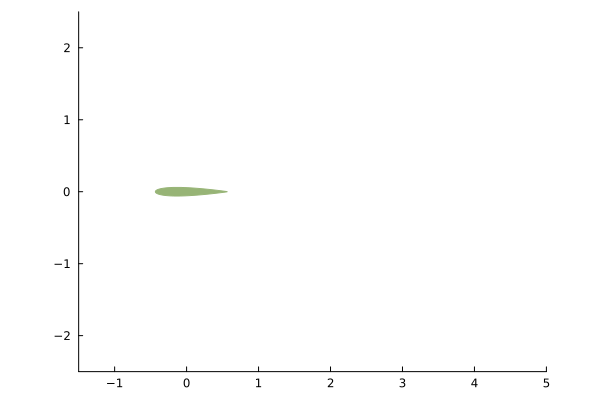

In [7]:
plot(body,xlim=xlim,ylim=ylim)

### The joint placement
We must specify the joint, attaching body 1 (the child) to the inertial system (body 0, the parent). We need
a more detailed form of the `Joint` function now. In this form, we need
to specify how the joint is attached to each body, and how each of its
degrees of freedom move. We will do this piece by piece to explain it.
More details can be found in the documentation for [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).

To place the joint, we need to specify its position in both the parent's
and the child's coordinate systems. In the parent's system, we can just
place it at the origin, with no rotation. For the child, we place
the joint where we want it on the body (in its own system). $(0,0)$ is the center of the body.

In [8]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [0.0,0.0] 
Xc = MotionTransform(xpiv,0.0)

2d motion transform, x = [0.0, 0.0], R = [1.0 0.0; -0.0 1.0]

### The kinematics
We are creating a joint that has three potential degrees of freedom (angle, x, y),
called a `FreeJoint2d`. However, only the angle and x coordinates of the
joint will be allowed to move. Both of these are assigned oscillatory kinematics.

In [9]:
Ω = π/2 # Flapping angular frequency
Tp = 2π/Ω # Period of flapping
Δα = 30π/180 # Amplitude of pitching
ϕα = 0 # Pitching phase
adof = OscillatoryDOF(Δα,Ω,ϕα,0.0)

Oscillatory kinematics (amplitude = 0.5235987755982988, ang freq = 1.5707963267948966, phase = 0.0, mean velocity = 0.0)

In [10]:
# so the Re = Ωc/ν is
Re_Ω = my_params["Re"]*Ω

314.1592653589793

Keep the x and y coordinates fixed

In [11]:
xdof = ConstantVelocityDOF(0)
ydof = ConstantVelocityDOF(0)

Constant velocity kinematics (velocity = 0.0)

We put the kinematics into a vector. The degrees of freedom are always ordered `[rotation, x, y]`.

In [12]:
dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Oscillatory kinematics (amplitude = 0.5235987755982988, ang freq = 1.5707963267948966, phase = 0.0, mean velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)

Finally, create the joint and the motion structure.

In [13]:
joint = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Now animate the motion for a complete cycle (4 time units)

[ Info: Saved animation to /Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif


Plots.AnimatedGif("/Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif")
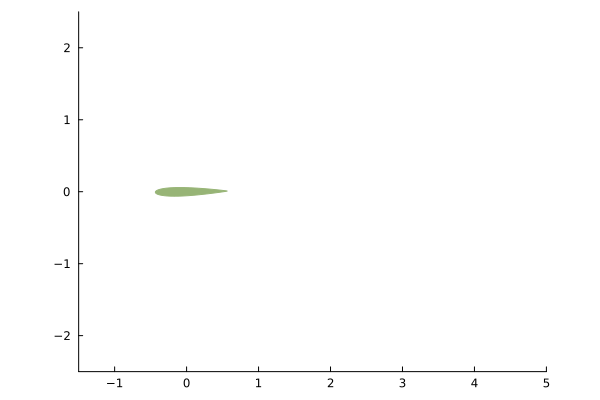

In [14]:
@animate_motion body m Tp/200 Tp xlim ylim

### Boundary condition functions

In [15]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

# This is for specifying zero velocity inside the body
function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply both the motion, the boundary condition functions, and the reference body as additional arguments.

In [16]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

### Set up the initial conditions
This is done the usual way

In [17]:
u0 = init_sol(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 440, ny = 338) cell grid of type Float64 data
  Number of Dual nodes: (nx = 440, ny = 338), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve the problem
Here, we will advance it for one flapping period

In [18]:
step!(integrator,Tp)

### Plot it
Plot the vorticity field in the coordinate system of the body

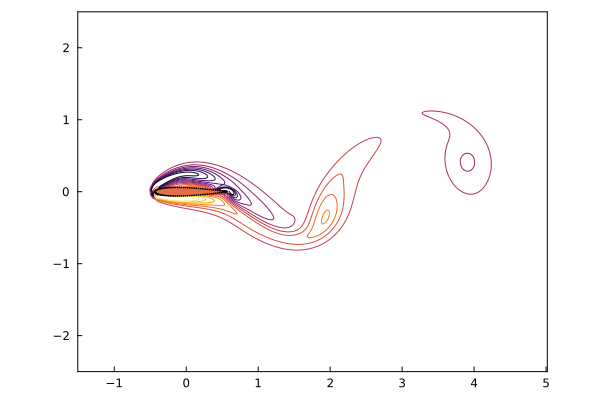

In [19]:
sol = integrator.sol
t = 4.0
p = plot(vorticity(sol,sys,t),sys,clim=(-10,10),levels=range(-10,10,length=16),ylim=(-2.5,2.5),bodyfill=true)

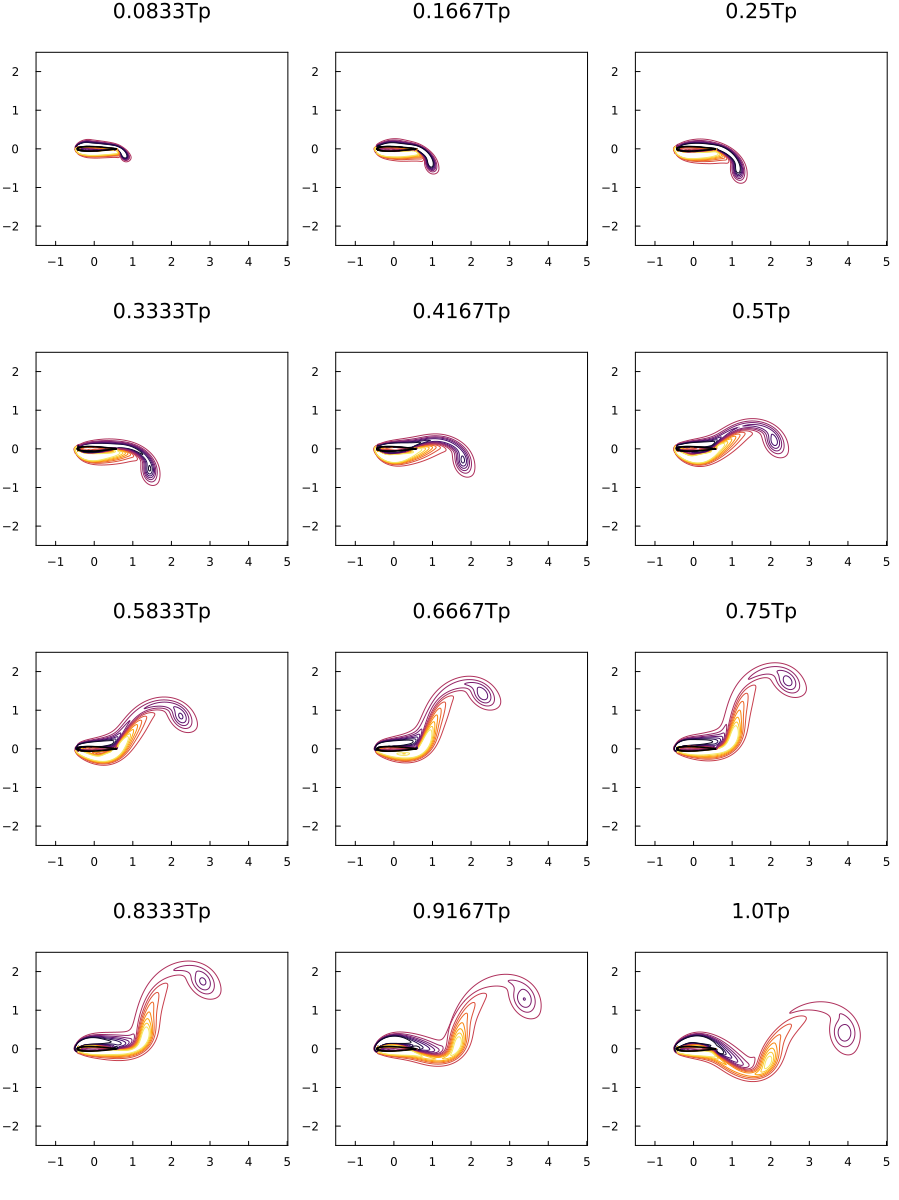

In [20]:
sol = integrator.sol
plt = plot(layout = (4,3), size = (900, 1200), legend=:false)
tsnap = Tp/12:Tp/12:Tp
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,clim=(-5,5),levels=range(-5,5,length=16),ylim=(-2.5,2.5),title="$(round(t/Tp,digits=4))Tp")
end
plt

#### To rotate the plot to its inertial coordinate system

In [21]:
using PythonPlot

In [22]:
function plot_pyplot(f::GridData,sol::ODESolution,sys::ILMSystem,t::Real)
    g = sys.base_cache.g
    α = aux_state(sol(t))[1]*180/pi
    x, y = coordinates(f,g)
    
    pts = points(sys)
    xb = [pts.u;]
    yb = [pts.v;]
    
    fig, ax = PythonPlot.subplots(figsize=(4,4))
    ax.set_aspect("equal")
    
    trans_data = PythonPlot.matplotlib.transforms.Affine2D().rotate_deg(α) + ax.transData
    ax.contour(x,y,f',levels=range(-5,5,length=30),transform=trans_data,linewidths=1,zorder=1)
    ax.fill(xb,yb,color="black",transform=trans_data,zorder=2)
    
    fig, ax
end

plot_pyplot (generic function with 1 method)

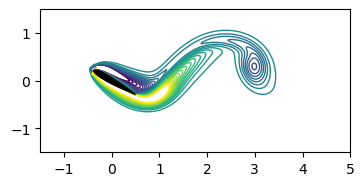

In [25]:
t = 3.0
w = vorticity(sol,sys,t)
fig, ax = plot_pyplot(w,sol,sys,t)
ax.set_xlim(-1.5,5)
ax.set_ylim(-1.5,1.5)
display(fig)

### Plot the forces and moments
The solution is expressed in co-rotating coordinates. To get the force and
moment in inertial coordinates, we
make use of the `axes` keyword, setting it to 0. The moment is computed
about the center of the body's coordinate system, but we can change that behavior
by using the `force_reference` keyword, setting it to 0, for example,
to compute the moment about the origin of the inertial system.

In [26]:
mom, fx, fy = force(sol,sys,1,axes=0);

Plot these

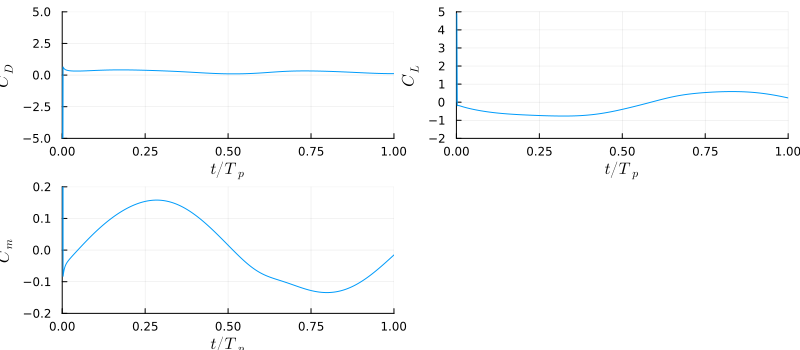

In [27]:
plot(
plot(sol.t/Tp,2*fx/Ω^2,xlim=(0,Inf),ylim=(-5,5),xlabel="\$t/T_p\$",ylabel="\$C_D\$",legend=:false),
plot(sol.t/Tp,2*fy/Ω^2,xlim=(0,Inf),ylim=(-2,5),xlabel="\$t/T_p\$",ylabel="\$C_L\$",legend=:false),
plot(sol.t/Tp,2*mom/Ω^2,xlim=(0,Inf),ylim=(-0.2,0.2),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)